# Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [1]:
NAME = "Umar Momen"
COLLABORATORS = ""

---

# Project 1: Trump, Twitter, and Text

Welcome to the first project of Data 100! In this project, we will work with the Twitter API in order to analyze Donald Trump's tweets.

**The project is due 11:59pm Tuesday, October 23, California Time.**

You do not have to work on this project before the midterm, but you might find it helpful, since it goes over a lot of pandas materials that we haven't used in a while.

**Fun:**

We intend this project to be fun! You will analyze actual data from the Twitter API. You will also draw conclusions about the current (and often controversial) US President's tweet behavior. If you find yourself getting frustrated or stuck on one problem for too long, we suggest coming into office hours and working with friends in the class.

With that in mind, let's get started!

In [2]:
# Run this cell to set up your notebook
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import zipfile

# Ensure that Pandas shows at least 280 characters in columns, so we can see full tweets
pd.set_option('max_colwidth', 280)

%matplotlib inline
plt.style.use('fivethirtyeight')
import seaborn as sns
sns.set()
sns.set_context("talk")
import re

# Downloading Recent Tweets

---

Since we'll be looking at Twitter data, we need to download the data from Twitter!

Twitter provides an API for downloading tweet data in large batches.  The `tweepy` package makes it fairly easy to use.

In [3]:
## Make sure you are in your data100 conda environment if you are working locally.
# The following should run:
import tweepy

There are instructions on using `tweepy` [here](http://tweepy.readthedocs.io/en/v3.5.0/getting_started.html), but we will give you example code.

Twitter requires you to have authentication keys to access their API.  To get your keys, you'll have to sign up as a Twitter developer.  The next question will walk you through this process.

## Question 1

Follow the instructions below to get your Twitter API keys.  **Read the instructions completely before starting.**

1. [Create a Twitter account](https://twitter.com).  You can use an existing account if you have one; if you prefer to not do this assignment under your regular account, feel free to create a throw-away account.
2. Under account settings, add your phone number to the account.
3. [Create a Twitter developer account](https://dev.twitter.com/resources/signup) by clicking the 'Apply' button on the top right of the page. Attach it to your Twitter account. You'll have to fill out a form describing what you want to do with the developer account. Explain that you are doing this for a class at UC Berkeley and that you don't know exactly what you're building yet and just need the account to get started. These applications are approved by some sort of AI system, so it doesn't matter exactly what you write. Just don't enter a bunch of alweiofalwiuhflawiuehflawuihflaiwhfe type stuff or you might get rejected.
4. Once you're logged into your developer account, [create an application for this assignment](https://apps.twitter.com/app/new).  You can call it whatever you want, and you can write any URL when it asks for a web site.  You don't need to provide a callback URL.
5. On the page for that application, find your Consumer Key and Consumer Secret.
6. On the same page, create an Access Token.  Record the resulting Access Token and Access Token Secret.
7. Edit the file [keys.json](keys.json) and replace the placeholders with your keys.  


## WARNING (Please Read) !!!!


### Protect your Twitter Keys
<span style="color:red">
If someone has your authentication keys, they can access your Twitter account and post as you!  So don't give them to anyone, and **don't write them down in this notebook**. 
</span>
The usual way to store sensitive information like this is to put it in a separate file and read it programmatically.  That way, you can share the rest of your code without sharing your keys.  That's why we're asking you to put your keys in `keys.json` for this assignment.


### Avoid making too many API calls.

<span style="color:red">
Twitter limits developers to a certain rate of requests for data.  If you make too many requests in a short period of time, you'll have to wait awhile (around 15 minutes) before you can make more.  </span> 
So carefully follow the code examples you see and don't rerun cells without thinking.  Instead, always save the data you've collected to a file.  We've provided templates to help you do that.


### Be careful about which functions you call!

<span style="color:red">
This API can retweet tweets, follow and unfollow people, and modify your twitter settings.  Be careful which functions you invoke! </span> One of the sp18 instructors accidentally re-tweeted some tweets because that instructor typed `retweet` instead of `retweet_count`. 
</span>


In [4]:
import json
key_file = 'keys.json'
# Loading your keys from keys.json (which you should have filled
# in in question 1):
with open(key_file) as f:
    keys = json.load(f)
# if you print or view the contents of keys be sure to delete the cell!

This cell tests the Twitter authentication. It should run without errors or warnings and display your Twitter username.

In [5]:
import tweepy
from tweepy import TweepError
import logging

try:
    auth = tweepy.OAuthHandler(keys["consumer_key"], keys["consumer_secret"])
    auth.set_access_token(keys["access_token"], keys["access_token_secret"])
    api = tweepy.API(auth)
    print("Your username is:", api.auth.get_username())
except TweepError as e:
    logging.warning("There was a Tweepy error. Double check your API keys and try again.")
    logging.warning(e)

Your username is: DS10017


## Question 2

In the example below, we have loaded some tweets by @BerkeleyData.  Run it and read the code.

In [6]:
from pathlib import Path
import json

ds_tweets_save_path = "BerkeleyData_recent_tweets.json"
# Guarding against attempts to download the data multiple
# times:
if not Path(ds_tweets_save_path).is_file():
    # Getting as many recent tweets by @BerkeleyData as Twitter will let us have.
    # We use tweet_mode='extended' so that Twitter gives us full 280 character tweets.
    # This was a change introduced in September 2017.
    
    # The tweepy Cursor API actually returns "sophisticated" Status objects but we 
    # will use the basic Python dictionaries stored in the _json field. 
    example_tweets = [t._json for t in tweepy.Cursor(api.user_timeline, id="BerkeleyData", 
                                             tweet_mode='extended').items()]
    
    # Saving the tweets to a json file on disk for future analysis
    with open(ds_tweets_save_path, "w") as f:        
        json.dump(example_tweets, f)

# Re-loading the json file:
with open(ds_tweets_save_path, "r") as f:
    example_tweets = json.load(f)

Assuming everything ran correctly you should be able to look at the first tweet by running the cell below.

<span style="color:red">
**Warning** Do not attempt to view all the tweets in a notebook.  It will likely freeze your browser.  The following would be a **bad idea**:
```python
    pprint(example_tweets)
```

</span> 

In [7]:
# Looking at one tweet object, which has type Status: 
from pprint import pprint # ...to get a more easily-readable view.
pprint(example_tweets[0])

{'contributors': None,
 'coordinates': None,
 'created_at': 'Wed Oct 17 14:12:03 +0000 2018',
 'display_text_range': [0, 140],
 'entities': {'hashtags': [],
              'symbols': [],
              'urls': [],
              'user_mentions': [{'id': 263020833,
                                 'id_str': '263020833',
                                 'indices': [3, 19],
                                 'name': 'Berkeley School of Information',
                                 'screen_name': 'BerkeleyISchool'},
                                {'id': 24414370,
                                 'id_str': '24414370',
                                 'indices': [26, 34],
                                 'name': 'Anno Saxenian',
                                 'screen_name': 'annosax'}]},
 'favorite_count': 0,
 'favorited': False,
 'full_text': 'RT @BerkeleyISchool: Dean @annosax is one 3 women who have '
              'authored key works to understand the current Entrepreneurial '
           

                               'followers_count': 4978,
                               'following': False,
                               'friends_count': 650,
                               'geo_enabled': True,
                               'has_extended_profile': False,
                               'id': 263020833,
                               'id_str': '263020833',
                               'is_translation_enabled': False,
                               'is_translator': False,
                               'lang': 'en',
                               'listed_count': 218,
                               'location': 'Berkeley, California, USA',
                               'name': 'Berkeley School of Information',
                               'notifications': False,
                               'profile_background_color': '38628F',
                               'profile_background_image_url': 'http://abs.twimg.com/images/themes/theme1/bg.png',
                        

## Question 2a

### What you need to do. 

Re-factor the above code fragment into reusable snippets below.  You should not need to make major modifications; this is mostly an exercise in understanding the above code block. 

In [8]:
def load_keys(path):
    """Loads your Twitter authentication keys from a file on disk.
    
    Args:
        path (str): The path to your key file.  The file should
          be in JSON format and look like this (but filled in):
            {
                "consumer_key": "<your Consumer Key here>",
                "consumer_secret":  "<your Consumer Secret here>",
                "access_token": "<your Access Token here>",
                "access_token_secret": "<your Access Token Secret here>"
            }
    
    Returns:
        dict: A dictionary mapping key names (like "consumer_key") to
          key values."""
    
    with open(key_file) as f:
        dick = json.load(f)
    return dick

In [9]:
def download_recent_tweets_by_user(user_account_name, keys):
    """Downloads tweets by one Twitter user.

    Args:
        user_account_name (str): The name of the Twitter account
          whose tweets will be downloaded.
        keys (dict): A Python dictionary with Twitter authentication
          keys (strings), like this (but filled in):
            {
                "consumer_key": "<your Consumer Key here>",
                "consumer_secret":  "<your Consumer Secret here>",
                "access_token": "<your Access Token here>",
                "access_token_secret": "<your Access Token Secret here>"
            }

    Returns:
        list: A list of Dictonary objects, each representing one tweet."""
    import tweepy
    try:
        auth = tweepy.OAuthHandler(keys["consumer_key"], keys["consumer_secret"])
        auth.set_access_token(keys["access_token"], keys["access_token_secret"])
        api = tweepy.API(auth)
        print("Your username is:", api.auth.get_username())
    except TweepError as e:
        logging.warning("There was a Tweepy error. Double check your API keys and try again.")
        logging.warning(e)
        
    downloaded_tweets = [t._json for t in tweepy.Cursor(api.user_timeline, id=user_account_name, tweet_mode='extended').items()]
    return downloaded_tweets
    

In [10]:
def save_tweets(tweets, path):
    """Saves a list of tweets to a file in the local filesystem.
    
    This function makes no guarantee about the format of the saved
    tweets, **except** that calling load_tweets(path) after
    save_tweets(tweets, path) will produce the same list of tweets
    and that only the file at the given path is used to store the
    tweets.  (That means you can implement this function however
    you want, as long as saving and loading works!)

    Args:
        tweets (list): A list of tweet objects (of type Dictionary) to
          be saved.
        path (str): The place where the tweets will be saved.

    Returns:
        None"""
    with open(path, "w") as f:        
        json.dump(tweets, f)

In [11]:
def load_tweets(path):
    """Loads tweets that have previously been saved.
    
    Calling load_tweets(path) after save_tweets(tweets, path)
    will produce the same list of tweets.
    
    Args:
        path (str): The place where the tweets were be saved.

    Returns:
        list: A list of Dictionary objects, each representing one tweet."""
    
    with open(path, "r") as f:
        example_tweets = json.load(f)
    return example_tweets

In [12]:
def get_tweets_with_cache(user_account_name, keys_path):
    """Get recent tweets from one user, loading from a disk cache if available.
    
    The first time you call this function, it will download tweets by
    a user.  Subsequent calls will not re-download the tweets; instead
    they'll load the tweets from a save file in your local filesystem.
    All this is done using the functions you defined in the previous cell.
    This has benefits and drawbacks that often appear when you cache data:
    
    +: Using this function will prevent extraneous usage of the Twitter API.
    +: You will get your data much faster after the first time it's called.
    -: If you really want to re-download the tweets (say, to get newer ones,
       or because you screwed up something in the previous cell and your
       tweets aren't what you wanted), you'll have to find the save file
       (which will look like <something>_recent_tweets.pkl) and delete it.
    
    Args:
        user_account_name (str): The Twitter handle of a user, without the @.
        keys_path (str): The path to a JSON keys file in your filesystem.
    """

    if not Path(user_account_name).is_file():
        keys = load_keys(keys_path)
        tweet_list = download_recent_tweets_by_user(user_account_name, keys)
        save_tweets(tweet_list, user_account_name)
    
    return load_tweets(user_account_name)

If everything was implemented correctly you should be able to obtain roughly the last 3000 tweets by the `realdonaldtrump`.  (This may take a few minutes)

In [13]:
# When you are done, run this cell to load @realdonaldtrump's tweets.
# Note the function get_tweets_with_cache.  You may find it useful
# later.
trump_tweets = get_tweets_with_cache("realdonaldtrump", key_file)
print("Number of tweets downloaded:", len(trump_tweets))

Number of tweets downloaded: 3224


In [14]:
assert 2000 <= len(trump_tweets) <= 4000

### Question 2b

We are limited to how many tweets we can download.  In what month is the oldest tweet from Trump?

In [15]:
# Enter the number of the month of the oldest tweet (e.g. 1 for January)
oldest_month = trump_tweets[-1]['created_at']
#oldest_month
oldest_month = 10



## Question 3


**IMPORTANT! PLEASE READ**

Unfortunately, Twitter prevent us from going further back in time using the public APIs.  Fortunately, we have a snapshot of earlier tweets that we can combine with our new data.  

We will again use the `fetch_and_cache` utility to download the dataset. 

In [16]:
# Download the dataset
from utils import fetch_and_cache
data_url = 'http://www.ds100.org/fa18/assets/datasets/old_trump_tweets.json.zip'
file_name = 'old_trump_tweets.json.zip'

dest_path = fetch_and_cache(data_url=data_url, file=file_name)
print(f'Located at {dest_path}')

Using version already downloaded: Sun Oct 21 04:27:15 2018
MD5 hash of file: b6e33874de91d1a40207cdf9f9b51a09
Located at data/old_trump_tweets.json.zip


Finally, we we will load the tweets directly from the compressed file without decompressing it first.

In [17]:
my_zip = zipfile.ZipFile(dest_path, 'r')
with my_zip.open("old_trump_tweets.json", "r") as f:
    old_trump_tweets = json.load(f)

This data is formatted identically to the recent tweets we just downloaded:

In [18]:
pprint(old_trump_tweets[0])

{'contributors': None,
 'coordinates': None,
 'created_at': 'Wed Oct 12 14:00:48 +0000 2016',
 'entities': {'hashtags': [{'indices': [23, 38], 'text': 'CrookedHillary'}],
              'media': [{'display_url': 'pic.twitter.com/wjsl8ITVvk',
                         'expanded_url': 'https://twitter.com/realDonaldTrump/status/786204978629185536/video/1',
                         'id': 786204885318561792,
                         'id_str': '786204885318561792',
                         'indices': [39, 62],
                         'media_url': 'http://pbs.twimg.com/ext_tw_video_thumb/786204885318561792/pu/img/XqMoixLm83FzkAbn.jpg',
                         'media_url_https': 'https://pbs.twimg.com/ext_tw_video_thumb/786204885318561792/pu/img/XqMoixLm83FzkAbn.jpg',
                         'sizes': {'large': {'h': 576,
                                             'resize': 'fit',
                                             'w': 1024},
                                   'medium': {'h': 338

As a dictionary we can also list the keys:

In [19]:
old_trump_tweets[0].keys()

dict_keys(['created_at', 'id', 'id_str', 'text', 'truncated', 'entities', 'extended_entities', 'source', 'in_reply_to_status_id', 'in_reply_to_status_id_str', 'in_reply_to_user_id', 'in_reply_to_user_id_str', 'in_reply_to_screen_name', 'user', 'geo', 'coordinates', 'place', 'contributors', 'is_quote_status', 'retweet_count', 'favorite_count', 'favorited', 'retweeted', 'possibly_sensitive', 'lang'])

Since we're giving you a zipfile of old tweets, you may wonder why we didn't just give you a zipfile of ALL tweets and save you the trouble of creating a Twitter developer account. The reason is that we wanted you to see what it's like to collect data from the real world on your own. It can be a pain!

### Question 3a

Merge the `old_trump_tweets` and the `trump_tweets` we downloaded from twitter into one giant list of tweets. 

**Important:** There may be some overlap so be sure to eliminate duplicate tweets.  
**Hint:** the `id` of a tweet is always unique.

In [20]:
TT_tweet_IDs = [x['id'] for x in trump_tweets]
Nonoverlaps = [x for x in old_trump_tweets if not(x['id'] in TT_tweet_IDs)]
all_tweets = trump_tweets + Nonoverlaps



In [21]:
assert len(all_tweets) > len(trump_tweets)
assert len(all_tweets) > len(old_trump_tweets)

### Question 3b

Construct a DataFrame called `trump` containing all the tweets stored in `all_tweets`. The index of the dataframe should be the ID of each tweet (looks something like `907698529606541312`). It should have these columns:

- `time`: The time the tweet was created encoded as a datetime object. (Use `pd.to_datetime` to encode the timestamp.)
- `source`: The source device of the tweet.
- `text`: The text of the tweet.
- `retweet_count`: The retweet count of the tweet. 

Finally, **the resulting dataframe should be sorted by the index.**

**Warning:** *Some tweets will store the text in the `text` field and other will use the `full_text` field.*

In [22]:
trump = pd.DataFrame([x['id'] for x in all_tweets])
trump["time"] = pd.to_datetime([x['created_at'] for x in all_tweets])
trump['source'] = [x['source'] for x in all_tweets]
trump['text'] = [x['text'] if 'text' in x else x['full_text'] for x in all_tweets]
trump['retweet_count'] = [x['retweet_count'] for x in all_tweets]
trump.index = trump[0]
trump.index.name = 'ID'
trump.head()

,0,time,source,text,retweet_count
ID,,,,,
1053807130120200192,1053807130120200192,2018-10-21 00:36:13,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","All levels of government and Law Enforcement are watching carefully for VOTER FRAUD, including during EARLY VOTING. Cheat at your own peril. Violators will be subject to maximum penalties, both civil and criminal!",10452
1053740855016574976,1053740855016574976,2018-10-20 20:12:52,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","Beautiful afternoon in Elko, Nevada. Thank you! Get out and VOTE TODAY!! #MAGA🇺🇸#JobsNotMobs https://t.co/0pWiwCq4MH https://t.co/AKfGzjrqCM",6602
1053684769991454721,1053684769991454721,2018-10-20 16:30:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","Heading to Nevada to help a man who has become a good friend, Senator Dean Heller. He is all about #MAGA and I need his Help and Talent in Washington. Also, Adam Laxalt will be a GREAT GOVERNOR, and has my complete and total Endorsement. Winners Both!",10572
1053682023066288128,1053682023066288128,2018-10-20 16:19:05,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","Leaving Arizona after a fantastic Rally last night, in Mesa, honoring, and for, Martha @RepMcSally McSally. She is an inspiration &amp; will be a GREAT SENATOR for the people of Arizona. Her opponent is a Nancy Pelosi puppet, really bad for State. Early Voting NOW! Will be ba...",10862
1053662989272793089,1053662989272793089,2018-10-20 15:03:27,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Rick Scott is known as easily one of the best Governors in the USA. Florida is setting records in almost every category of success. Amazing achievement-the envy of the World. Ron DeSantis will build on this success. His incompetent opponent will destroy Florida - next Venezuela!,13169


In [23]:
assert isinstance(trump, pd.DataFrame)
assert trump.shape[0] < 11000
assert trump.shape[1] >= 4
assert 831846101179314177 in trump.index
assert 753063644578144260 in trump.index
assert all(col in trump.columns for col in ['time', 'source', 'text', 'retweet_count'])
# If you fail these tests, you probably tried to use __dict__ or _json to read in the tweets
assert np.sometrue([('Twitter for iPhone' in s) for s in trump['source'].unique()])
assert trump['time'].dtype == np.dtype('<M8[ns]')
assert trump['text'].dtype == np.dtype('O')
assert trump['retweet_count'].dtype == np.dtype('int64')

## Question 4: Tweet Source Analysis

In the following questions, we are going to find out the charateristics of Trump tweets and the devices used for the tweets.

First let's examine the source field:

In [24]:
trump['source'].unique()

array([ '<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
       '<a href="https://studio.twitter.com" rel="nofollow">Media Studio</a>',
       '<a href="http://twitter.com/#!/download/ipad" rel="nofollow">Twitter for iPad</a>',
       '<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>',
       '<a href="http://twitter.com/download/android" rel="nofollow">Twitter for Android</a>',
       '<a href="http://instagram.com" rel="nofollow">Instagram</a>',
       '<a href="https://mobile.twitter.com" rel="nofollow">Mobile Web (M5)</a>',
       '<a href="https://ads.twitter.com" rel="nofollow">Twitter Ads</a>',
       '<a href="https://periscope.tv" rel="nofollow">Periscope</a>'], dtype=object)

## Question 4a

Remove the HTML tags from the source field. 

**Hint:** Use `trump['source'].str.replace` and your favorite regular expression.

In [25]:
import re
regx = r"<.*>(.*)<.*>"

trump['source'] = [re.search("<.*>(.*)<.*>", x).group(1) for x in list(trump['source'])]
trump.head()


,0,time,source,text,retweet_count
ID,,,,,
1053807130120200192,1053807130120200192,2018-10-21 00:36:13,Twitter for iPhone,"All levels of government and Law Enforcement are watching carefully for VOTER FRAUD, including during EARLY VOTING. Cheat at your own peril. Violators will be subject to maximum penalties, both civil and criminal!",10452
1053740855016574976,1053740855016574976,2018-10-20 20:12:52,Twitter for iPhone,"Beautiful afternoon in Elko, Nevada. Thank you! Get out and VOTE TODAY!! #MAGA🇺🇸#JobsNotMobs https://t.co/0pWiwCq4MH https://t.co/AKfGzjrqCM",6602
1053684769991454721,1053684769991454721,2018-10-20 16:30:00,Twitter for iPhone,"Heading to Nevada to help a man who has become a good friend, Senator Dean Heller. He is all about #MAGA and I need his Help and Talent in Washington. Also, Adam Laxalt will be a GREAT GOVERNOR, and has my complete and total Endorsement. Winners Both!",10572
1053682023066288128,1053682023066288128,2018-10-20 16:19:05,Twitter for iPhone,"Leaving Arizona after a fantastic Rally last night, in Mesa, honoring, and for, Martha @RepMcSally McSally. She is an inspiration &amp; will be a GREAT SENATOR for the people of Arizona. Her opponent is a Nancy Pelosi puppet, really bad for State. Early Voting NOW! Will be ba...",10862
1053662989272793089,1053662989272793089,2018-10-20 15:03:27,Twitter for iPhone,Rick Scott is known as easily one of the best Governors in the USA. Florida is setting records in almost every category of success. Amazing achievement-the envy of the World. Ron DeSantis will build on this success. His incompetent opponent will destroy Florida - next Venezuela!,13169


In [26]:
from datetime import datetime
ELEC_DATE = datetime(2016, 11, 8)
INAUG_DATE = datetime(2017, 1, 20)
assert set(trump[(trump['time'] > ELEC_DATE) & (trump['time'] < INAUG_DATE) ]['source'].unique()) == set(['Twitter Ads',
 'Twitter Web Client',
 'Twitter for Android',
 'Twitter for iPhone'])

We can see in the following plot that there are two device types that are more commonly used

Text(0,0.5,'Number of Tweets')

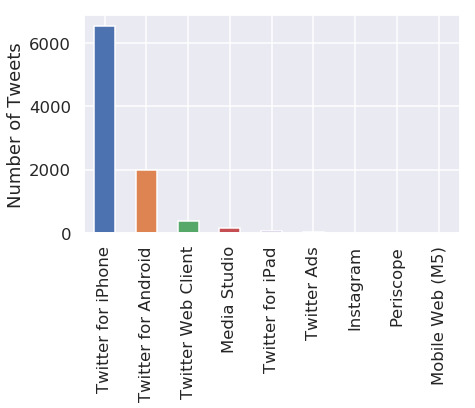

In [27]:
trump['source'].value_counts().plot(kind="bar")
plt.ylabel("Number of Tweets")

## Question 4b


Is there a difference between his Tweet behavior across these devices? We will attempt to answer this question in our subsequent analysis.

First, we'll take a look at whether Trump's tweets from an Android come at different times than his tweets from an iPhone. Note that Twitter gives us his tweets in the [UTC timezone](https://www.wikiwand.com/en/List_of_UTC_time_offsets) (notice the `+0000` in the first few tweets)

In [28]:
for t in trump_tweets[0:3]:
    print(t['created_at'])

Sun Oct 21 00:36:13 +0000 2018
Sat Oct 20 20:12:52 +0000 2018
Sat Oct 20 16:30:00 +0000 2018


We'll convert the tweet times to US Eastern Time, the timezone of New York and Washington D.C., since those are the places we would expect the most tweet activity from Trump.

In [29]:
trump['est_time'] = (
    trump['time'].dt.tz_localize("UTC") # Set initial timezone to UTC
                 .dt.tz_convert("EST") # Convert to Eastern Time
)
trump.head()

,0,time,source,text,retweet_count,est_time
ID,,,,,,
1053807130120200192,1053807130120200192,2018-10-21 00:36:13,Twitter for iPhone,"All levels of government and Law Enforcement are watching carefully for VOTER FRAUD, including during EARLY VOTING. Cheat at your own peril. Violators will be subject to maximum penalties, both civil and criminal!",10452,2018-10-20 19:36:13-05:00
1053740855016574976,1053740855016574976,2018-10-20 20:12:52,Twitter for iPhone,"Beautiful afternoon in Elko, Nevada. Thank you! Get out and VOTE TODAY!! #MAGA🇺🇸#JobsNotMobs https://t.co/0pWiwCq4MH https://t.co/AKfGzjrqCM",6602,2018-10-20 15:12:52-05:00
1053684769991454721,1053684769991454721,2018-10-20 16:30:00,Twitter for iPhone,"Heading to Nevada to help a man who has become a good friend, Senator Dean Heller. He is all about #MAGA and I need his Help and Talent in Washington. Also, Adam Laxalt will be a GREAT GOVERNOR, and has my complete and total Endorsement. Winners Both!",10572,2018-10-20 11:30:00-05:00
1053682023066288128,1053682023066288128,2018-10-20 16:19:05,Twitter for iPhone,"Leaving Arizona after a fantastic Rally last night, in Mesa, honoring, and for, Martha @RepMcSally McSally. She is an inspiration &amp; will be a GREAT SENATOR for the people of Arizona. Her opponent is a Nancy Pelosi puppet, really bad for State. Early Voting NOW! Will be ba...",10862,2018-10-20 11:19:05-05:00
1053662989272793089,1053662989272793089,2018-10-20 15:03:27,Twitter for iPhone,Rick Scott is known as easily one of the best Governors in the USA. Florida is setting records in almost every category of success. Amazing achievement-the envy of the World. Ron DeSantis will build on this success. His incompetent opponent will destroy Florida - next Venezuela!,13169,2018-10-20 10:03:27-05:00


**What you need to do:**

Add a column called `hour` to the `trump` table which contains the hour of the day as floating point number computed by:

$$
\text{hour} + \frac{\text{minute}}{60} + \frac{\text{second}}{60^2}
$$


In [30]:
trump['hour'] = trump['est_time'].apply(lambda x: x.hour) + trump['est_time'].apply(lambda x: (x.minute)/60) + trump['est_time'].apply(lambda x: (x.second)/(60**2))


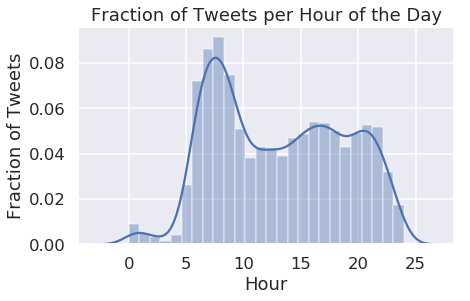

In [31]:
sns.distplot(trump['hour'])
plt.ylabel("Fraction of Tweets")
plt.xlabel("Hour")
plt.title('Fraction of Tweets per Hour of the Day')
plt.show()

In [32]:
trump['source'].value_counts()

Twitter for iPhone     6543
Twitter for Android    1982
Twitter Web Client      365
Media Studio            159
Twitter for iPad         59
Twitter Ads              34
Instagram                 2
Periscope                 1
Mobile Web (M5)           1
Name: source, dtype: int64

In [33]:
assert np.isclose(trump.loc[690171032150237184]['hour'], 8.93639)

## Question 4c

Use this data along with the seaborn `distplot` function to examine the distribution over hours of the day in eastern time that trump tweets on each device for the 2 most commonly used devices.  Your plot should look similar to the following. 

<img src="images/device_hour2.png" width="600px" />

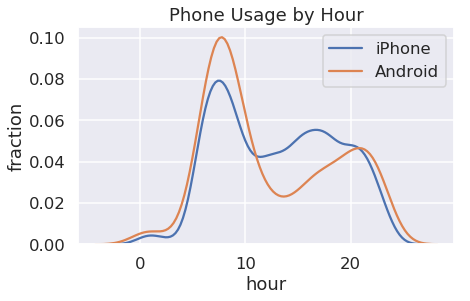

In [34]:
### make your plot here
sns.distplot(trump[trump['source'] == "Twitter for iPhone"]['hour'], hist = False, label = 'iPhone')
sns.distplot(trump[trump['source'] == "Twitter for Android"]['hour'], hist = False, label = 'Android')
plt.ylabel('fraction')
plt.title('Phone Usage by Hour')
plt.legend()
plt.show()


## Question 4d

According to [this Verge article](https://www.theverge.com/2017/3/29/15103504/donald-trump-iphone-using-switched-android), Donald Trump switched from an Android to an iPhone sometime in March 2017.

Create a figure identical to your figure from 4c, except that you should show the results only from 2016.

During the campaign, it was theorized that Donald Trump's tweets from Android were written by him personally, and the tweets from iPhone were from his staff. Does your figure give support to this theory?

In [35]:
trump['year'] = trump['est_time'].apply(lambda x: x.year)
trump.head()

,0,time,source,text,retweet_count,est_time,hour,year
ID,,,,,,,,
1053807130120200192,1053807130120200192,2018-10-21 00:36:13,Twitter for iPhone,"All levels of government and Law Enforcement are watching carefully for VOTER FRAUD, including during EARLY VOTING. Cheat at your own peril. Violators will be subject to maximum penalties, both civil and criminal!",10452,2018-10-20 19:36:13-05:00,19.603611,2018
1053740855016574976,1053740855016574976,2018-10-20 20:12:52,Twitter for iPhone,"Beautiful afternoon in Elko, Nevada. Thank you! Get out and VOTE TODAY!! #MAGA🇺🇸#JobsNotMobs https://t.co/0pWiwCq4MH https://t.co/AKfGzjrqCM",6602,2018-10-20 15:12:52-05:00,15.214444,2018
1053684769991454721,1053684769991454721,2018-10-20 16:30:00,Twitter for iPhone,"Heading to Nevada to help a man who has become a good friend, Senator Dean Heller. He is all about #MAGA and I need his Help and Talent in Washington. Also, Adam Laxalt will be a GREAT GOVERNOR, and has my complete and total Endorsement. Winners Both!",10572,2018-10-20 11:30:00-05:00,11.500000,2018
1053682023066288128,1053682023066288128,2018-10-20 16:19:05,Twitter for iPhone,"Leaving Arizona after a fantastic Rally last night, in Mesa, honoring, and for, Martha @RepMcSally McSally. She is an inspiration &amp; will be a GREAT SENATOR for the people of Arizona. Her opponent is a Nancy Pelosi puppet, really bad for State. Early Voting NOW! Will be ba...",10862,2018-10-20 11:19:05-05:00,11.318056,2018
1053662989272793089,1053662989272793089,2018-10-20 15:03:27,Twitter for iPhone,Rick Scott is known as easily one of the best Governors in the USA. Florida is setting records in almost every category of success. Amazing achievement-the envy of the World. Ron DeSantis will build on this success. His incompetent opponent will destroy Florida - next Venezuela!,13169,2018-10-20 10:03:27-05:00,10.057500,2018


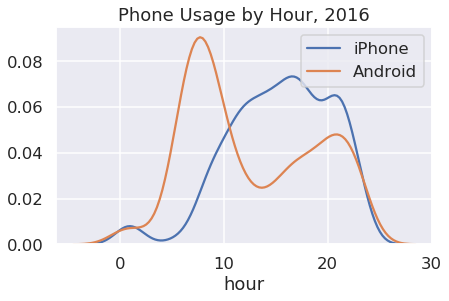

In [36]:
trumpyear = trump[trump['year'] == 2016]
sns.distplot(trumpyear[trumpyear['source'] == "Twitter for iPhone"]['hour'], hist = False, label = 'iPhone')
sns.distplot(trumpyear[trumpyear['source'] == "Twitter for Android"]['hour'], hist = False, label = 'Android')
plt.title('Phone Usage by Hour, 2016')
plt.show()

The figure shows that Android usage has bimodal peaks around the 7th-8th and 20th-21st hours of the day. iPhone usage also has bimodal peaks around 16 and 22 hours. The first peaks of both iPhone usage and Android usage occur near the local minima of the other graph, i.e. iPhone usage first peaks when Android usage is at a minima and Android usage first peaks when iPhone usage is near a minima. This could signify that there are two groups who are tweeting on their own time. The second peaks of both graphs are around the same time, so both groups might be active then as well. This could correspond to the schedule of Trump as well as his staff, as his staff would be tweeting around the same time on their iPhones while Trump could tweet whenever he wanted on his Android.

## Question 5

Let's now look at which device he has used over the entire time period of this dataset.

To examine the distribution of dates we will convert the date to a fractional year that can be plotted as a distribution.

(Code borrowed from https://stackoverflow.com/questions/6451655/python-how-to-convert-datetime-dates-to-decimal-years)

In [37]:
import datetime
def year_fraction(date):
    start = datetime.date(date.year, 1, 1).toordinal()
    year_length = datetime.date(date.year+1, 1, 1).toordinal() - start
    return date.year + float(date.toordinal() - start) / year_length


trump['year'] = trump['time'].apply(year_fraction)

### Question 5a

Use the `sns.distplot` to overlay the distributions of the 2 most frequently used web technologies over the years.  Your final plot should look like:

<img src="images/source_years.png" width="600px" />


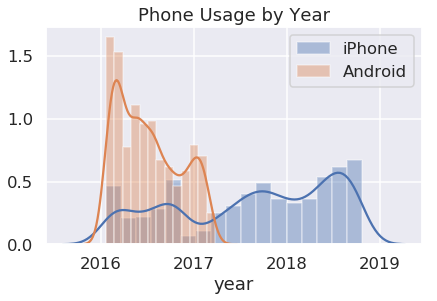

In [38]:
sns.distplot(trump[trump['source'] == "Twitter for iPhone"]['year'], label = 'iPhone')
sns.distplot(trump[trump['source'] == "Twitter for Android"]['year'], label = 'Android')
plt.legend()
plt.title('Phone Usage by Year')
plt.show()

## Question 6: Sentiment Analysis

It turns out that we can use the words in Trump's tweets to calculate a measure of the sentiment of the tweet. For example, the sentence "I love America!" has positive sentiment, whereas the sentence "I hate taxes!" has a negative sentiment. In addition, some words have stronger positive / negative sentiment than others: "I love America." is more positive than "I like America."

We will use the [VADER (Valence Aware Dictionary and sEntiment Reasoner)](https://github.com/cjhutto/vaderSentiment) lexicon to analyze the sentiment of Trump's tweets. VADER is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media which is great for our usage.

The VADER lexicon gives the sentiment of individual words. Run the following cell to show the first few rows of the lexicon:

In [39]:
print(''.join(open("vader_lexicon.txt").readlines()[:10]))

$:	-1.5	0.80623	[-1, -1, -1, -1, -3, -1, -3, -1, -2, -1]
%)	-0.4	1.0198	[-1, 0, -1, 0, 0, -2, -1, 2, -1, 0]
%-)	-1.5	1.43178	[-2, 0, -2, -2, -1, 2, -2, -3, -2, -3]
&-:	-0.4	1.42829	[-3, -1, 0, 0, -1, -1, -1, 2, -1, 2]
&:	-0.7	0.64031	[0, -1, -1, -1, 1, -1, -1, -1, -1, -1]
( '}{' )	1.6	0.66332	[1, 2, 2, 1, 1, 2, 2, 1, 3, 1]
(%	-0.9	0.9434	[0, 0, 1, -1, -1, -1, -2, -2, -1, -2]
('-:	2.2	1.16619	[4, 1, 4, 3, 1, 2, 3, 1, 2, 1]
(':	2.3	0.9	[1, 3, 3, 2, 2, 4, 2, 3, 1, 2]
((-:	2.1	0.53852	[2, 2, 2, 1, 2, 3, 2, 2, 3, 2]



## Question 6a

As you can see, the lexicon contains emojis too! The first column of the lexicon is the *token*, or the word itself. The second column is the *polarity* of the word, or how positive / negative it is.

(How did they decide the polarities of these words? What are the other two columns in the lexicon? See the link above.)

 Read in the lexicon into a DataFrame called `sent`. The index of the DF should be the tokens in the lexicon. `sent` should have one column: `polarity`: The polarity of each token.

In [40]:
pre_sent = pd.read_csv("vader_lexicon.txt", sep='\t', names = ['token', 'polarity', 'somethingelse', 'yah'])
sent = pre_sent['polarity']
sent.index = pre_sent['token']


In [41]:
sent = pd.DataFrame(sent)

In [42]:
sent.head()

,polarity
token,
$:,-1.5
%),-0.4
%-),-1.5
&-:,-0.4
&:,-0.7


In [43]:
assert isinstance(sent, pd.DataFrame)
assert sent.shape == (7517, 1)
assert list(sent.index[5000:5005]) == ['paranoids', 'pardon', 'pardoned', 'pardoning', 'pardons']
assert np.allclose(sent['polarity'].head(), [-1.5, -0.4, -1.5, -0.4, -0.7])

## Question 6b

Now, let's use this lexicon to calculate the overall sentiment for each of Trump's tweets. Here's the basic idea:

1. For each tweet, find the sentiment of each word.
2. Calculate the sentiment of each tweet by taking the sum of the sentiments of its words.

First, let's lowercase the text in the tweets since the lexicon is also lowercase. Set the `text` column of the `trump` DF to be the lowercased text of each tweet.

In [44]:
trump['text'] = trump['text'].str.lower()

In [45]:
trump.head()

,0,time,source,text,retweet_count,est_time,hour,year
ID,,,,,,,,
1053807130120200192,1053807130120200192,2018-10-21 00:36:13,Twitter for iPhone,"all levels of government and law enforcement are watching carefully for voter fraud, including during early voting. cheat at your own peril. violators will be subject to maximum penalties, both civil and criminal!",10452,2018-10-20 19:36:13-05:00,19.603611,2018.80274
1053740855016574976,1053740855016574976,2018-10-20 20:12:52,Twitter for iPhone,"beautiful afternoon in elko, nevada. thank you! get out and vote today!! #maga🇺🇸#jobsnotmobs https://t.co/0pwiwcq4mh https://t.co/akfgzjrqcm",6602,2018-10-20 15:12:52-05:00,15.214444,2018.80000
1053684769991454721,1053684769991454721,2018-10-20 16:30:00,Twitter for iPhone,"heading to nevada to help a man who has become a good friend, senator dean heller. he is all about #maga and i need his help and talent in washington. also, adam laxalt will be a great governor, and has my complete and total endorsement. winners both!",10572,2018-10-20 11:30:00-05:00,11.500000,2018.80000
1053682023066288128,1053682023066288128,2018-10-20 16:19:05,Twitter for iPhone,"leaving arizona after a fantastic rally last night, in mesa, honoring, and for, martha @repmcsally mcsally. she is an inspiration &amp; will be a great senator for the people of arizona. her opponent is a nancy pelosi puppet, really bad for state. early voting now! will be ba...",10862,2018-10-20 11:19:05-05:00,11.318056,2018.80000
1053662989272793089,1053662989272793089,2018-10-20 15:03:27,Twitter for iPhone,rick scott is known as easily one of the best governors in the usa. florida is setting records in almost every category of success. amazing achievement-the envy of the world. ron desantis will build on this success. his incompetent opponent will destroy florida - next venezuela!,13169,2018-10-20 10:03:27-05:00,10.057500,2018.80000


In [46]:
assert trump['text'].loc[884740553040175104] == 'working hard to get the olympics for the united states (l.a.). stay tuned!'

## Question 6c

Now, let's get rid of punctuation since it'll cause us to fail to match words. Create a new column called `no_punc` in the `trump` DF to be the lowercased text of each tweet with all punctuation replaced by a single space. We consider punctuation characters to be any character that isn't a Unicode word character or a whitespace character. You may want to consult the Python documentation on regexes for this problem.

(Why don't we simply remove punctuation instead of replacing with a space? See if you can figure this out by looking at the tweet data.)

In [47]:
# Save your regex in punct_re
punct_re = r'[^(\s\w)]'
trump['no_punc'] = trump['text'].str.replace(punct_re,' ')
trump.head()

,0,time,source,text,retweet_count,est_time,hour,year,no_punc
ID,,,,,,,,,
1053807130120200192,1053807130120200192,2018-10-21 00:36:13,Twitter for iPhone,"all levels of government and law enforcement are watching carefully for voter fraud, including during early voting. cheat at your own peril. violators will be subject to maximum penalties, both civil and criminal!",10452,2018-10-20 19:36:13-05:00,19.603611,2018.80274,all levels of government and law enforcement are watching carefully for voter fraud including during early voting cheat at your own peril violators will be subject to maximum penalties both civil and criminal
1053740855016574976,1053740855016574976,2018-10-20 20:12:52,Twitter for iPhone,"beautiful afternoon in elko, nevada. thank you! get out and vote today!! #maga🇺🇸#jobsnotmobs https://t.co/0pwiwcq4mh https://t.co/akfgzjrqcm",6602,2018-10-20 15:12:52-05:00,15.214444,2018.80000,beautiful afternoon in elko nevada thank you get out and vote today maga jobsnotmobs https t co 0pwiwcq4mh https t co akfgzjrqcm
1053684769991454721,1053684769991454721,2018-10-20 16:30:00,Twitter for iPhone,"heading to nevada to help a man who has become a good friend, senator dean heller. he is all about #maga and i need his help and talent in washington. also, adam laxalt will be a great governor, and has my complete and total endorsement. winners both!",10572,2018-10-20 11:30:00-05:00,11.500000,2018.80000,heading to nevada to help a man who has become a good friend senator dean heller he is all about maga and i need his help and talent in washington also adam laxalt will be a great governor and has my complete and total endorsement winners both
1053682023066288128,1053682023066288128,2018-10-20 16:19:05,Twitter for iPhone,"leaving arizona after a fantastic rally last night, in mesa, honoring, and for, martha @repmcsally mcsally. she is an inspiration &amp; will be a great senator for the people of arizona. her opponent is a nancy pelosi puppet, really bad for state. early voting now! will be ba...",10862,2018-10-20 11:19:05-05:00,11.318056,2018.80000,leaving arizona after a fantastic rally last night in mesa honoring and for martha repmcsally mcsally she is an inspiration amp will be a great senator for the people of arizona her opponent is a nancy pelosi puppet really bad for state early voting now will be ba...
1053662989272793089,1053662989272793089,2018-10-20 15:03:27,Twitter for iPhone,rick scott is known as easily one of the best governors in the usa. florida is setting records in almost every category of success. amazing achievement-the envy of the world. ron desantis will build on this success. his incompetent opponent will destroy florida - next venezuela!,13169,2018-10-20 10:03:27-05:00,10.057500,2018.80000,rick scott is known as easily one of the best governors in the usa florida is setting records in almost every category of success amazing achievement the envy of the world ron desantis will build on this success his incompetent opponent will destroy florida next venezuela


In [48]:
assert isinstance(punct_re, str)
assert re.search(punct_re, 'this') is None
assert re.search(punct_re, 'this is ok') is None
assert re.search(punct_re, 'this is\nok') is None
assert re.search(punct_re, 'this is not ok.') is not None
assert re.search(punct_re, 'this#is#ok') is not None
assert re.search(punct_re, 'this^is ok') is not None
assert trump['no_punc'].loc[800329364986626048] == 'i watched parts of  nbcsnl saturday night live last night  it is a totally one sided  biased show   nothing funny at all  equal time for us '
assert trump['no_punc'].loc[894620077634592769] == 'on  purpleheartday i thank all the brave men and women who have sacrificed in battle for this great nation   usa   https   t co qmfdlslp6p'
# If you fail these tests, you accidentally changed the text column
assert trump['text'].loc[884740553040175104] == 'working hard to get the olympics for the united states (l.a.). stay tuned!'

## Question 6d:


Now, let's convert the tweets into what's called a [*tidy format*](https://cran.r-project.org/web/packages/tidyr/vignettes/tidy-data.html) to make the sentiments easier to calculate. Use the `no_punc` column of `trump` to create a table called `tidy_format`. The index of the table should be the IDs of the tweets, repeated once for every word in the tweet. It has two columns:

1. `num`: The location of the word in the tweet. For example, if the tweet was "i love america", then the location of the word "i" is 0, "love" is 1, and "america" is 2.
2. `word`: The individual words of each tweet.

The first few rows of our `tidy_format` table look like:

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>num</th>
      <th>word</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>894661651760377856</th>
      <td>0</td>
      <td>i</td>
    </tr>
    <tr>
      <th>894661651760377856</th>
      <td>1</td>
      <td>think</td>
    </tr>
    <tr>
      <th>894661651760377856</th>
      <td>2</td>
      <td>senator</td>
    </tr>
    <tr>
      <th>894661651760377856</th>
      <td>3</td>
      <td>blumenthal</td>
    </tr>
    <tr>
      <th>894661651760377856</th>
      <td>4</td>
      <td>should</td>
    </tr>
  </tbody>
</table>

**Note that you'll get different results depending on when you pulled in the tweets.** However, you can double check that your tweet with ID `894661651760377856` has the same rows as ours. Our tests don't check whether your table looks exactly like ours.

As usual, try to avoid using any for loops. Our solution uses a chain of 5 methods on the 'trump' DF, albeit using some rather advanced Pandas hacking.

* **Hint 1:** Try looking at the `expand` argument to pandas' `str.split`.

* **Hint 2:** Try looking at the `stack()` method.

* **Hint 3:** Try looking at the `level` parameter of the `reset_index` method.


In [49]:
s = trump['no_punc'].str.split(expand = True).stack().to_frame().reset_index(level = 'ID')
s['num'] = s.index
s.index = s['ID']
s = s.drop(s.columns[0], axis=1)
s.columns = ['word', 'num']
del s.index.name
tidy_format = s

In [50]:
assert tidy_format.loc[894661651760377856].shape == (27, 2)
assert ' '.join(list(tidy_format.loc[894661651760377856]['word'])) == 'i think senator blumenthal should take a nice long vacation in vietnam where he lied about his service so he can at least say he was there'

## Question 6e:

Now that we have this table in the tidy format, it becomes much easier to find the sentiment of each tweet: we can join the table with the lexicon table. 

Add a `polarity` column to the `trump` table.  The `polarity` column should contain the sum of the sentiment polarity of each word in the text of the tweet.

**Hint** you will need to merge the `tidy_format` and `sent` tables and group the final answer.


In [51]:
test = tidy_format.merge(sent, left_on = 'word', right_index = True, how = 'left').fillna(0)#.groupby(tidy_format.index)['polarity'].sum()
test = test.groupby(level = 0)['polarity'].sum()
trump['polarity'] = test

In [52]:
assert np.allclose(trump.loc[744701872456536064, 'polarity'], 8.4)
assert np.allclose(trump.loc[745304731346702336, 'polarity'], 2.5)
assert np.allclose(trump.loc[744519497764184064, 'polarity'], 1.7)
assert np.allclose(trump.loc[894661651760377856, 'polarity'], 0.2)
assert np.allclose(trump.loc[894620077634592769, 'polarity'], 5.4)
# If you fail this test, you dropped tweets with 0 polarity
assert np.allclose(trump.loc[744355251365511169, 'polarity'], 0.0)

Now we have a measure of the sentiment of each of his tweets! Note that this calculation is rather basic; you can read over the VADER readme to understand a more robust sentiment analysis.

Now, run the cells below to see the most positive and most negative tweets from Trump in your dataset:

In [53]:
print('Most negative tweets:')
for t in trump.sort_values('polarity').head()['text']:
    print('\n  ', t)

Most negative tweets:

   it is outrageous that poisonous synthetic heroin fentanyl comes pouring into the u.s. postal system from china. we can, and must, end this now! the senate should pass the stop act – and firmly stop this poison from killing our children and destroying our country. no more delay!

   the rigged russian witch hunt goes on and on as the “originators and founders” of this scam continue to be fired and demoted for their corrupt and illegal activity. all credibility is gone from this terrible hoax, and much more will be lost as it proceeds. no collusion!

   james comey is a proven leaker &amp; liar. virtually everyone in washington thought he should be fired for the terrible job he did-until he was, in fact, fired. he leaked classified information, for which he should be prosecuted. he lied to congress under oath. he is a weak and.....

   there is no collusion! the robert mueller rigged witch hunt, headed now by 17 (increased from 13, including an obama white house

In [54]:
print('Most positive tweets:')
for t in trump.sort_values('polarity', ascending=False).head()['text']:
    print('\n  ', t)

Most positive tweets:

   congratulations to patrick reed on his great and courageous masters win! when patrick had his amazing win at doral 5 years ago, people saw his great talent, and a bright future ahead. now he is the masters champion!

   my supporters are the smartest, strongest, most hard working and most loyal that we have seen in our countries history. it is a beautiful thing to watch as we win elections and gather support from all over the country. as we get stronger, so does our country. best numbers ever!

   thank you to all of my great supporters, really big progress being made. other countries wanting to fix crazy trade deals. economy is roaring. supreme court pick getting great reviews. new poll says trump, at over 90%, is the most popular republican in history of the party. wow!

   thank you, @wvgovernor jim justice, for that warm introduction. tonight, it was my great honor to attend the “greenbrier classic – salute to service dinner” in west virginia! god bless ou

## Question 6g

Plot the distribution of tweet sentiments broken down by whether the text of the tweet contains `nyt` or `fox`.  Then in the box below comment on what we observe?

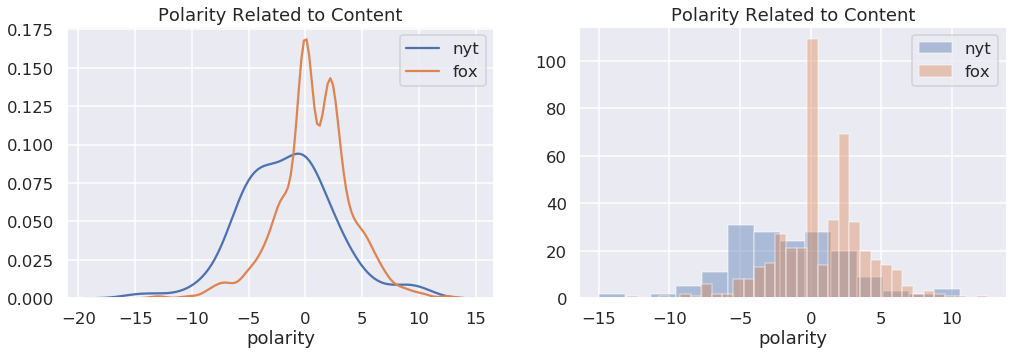

In [55]:
trumpnyt = trump[trump['no_punc'].str.contains('nyt')]
trumpfox = trump[trump['no_punc'].str.contains('fox')]
plt.figure(figsize = (15, 5))
plt.subplot(1, 2, 1)
sns.distplot(trumpnyt['polarity'], label = 'nyt', hist = False)
sns.distplot(trumpfox['polarity'], label = 'fox', hist = False)
plt.title('Polarity Related to Content')
plt.subplot(1, 2, 2)
sns.distplot(trumpnyt['polarity'], label = 'nyt', hist = True, kde = False)
sns.distplot(trumpfox['polarity'], label = 'fox', hist = True, kde = False)
plt.title('Polarity Related to Content')
plt.legend()
plt.show()

#### Comment on what you observe:

The histogram and KDE for 'nyt' show somewhat different patterns. The KDE provides a good overview and shows that overall, the polarity is slightly left skewed from the peak, with the density spread out mostly between -7 and 3, with the 'peak' from -5 to 0, and not a very clear bimodal relationship. 
The Histogram for nyt shows more of a visible bimodal relationship, with the tallest peak around -5 and another peak around 1 (in contrast to the KDE which shows a taller peak near zero). 
In both KDE and histogram, the data is quite spread out, indicating there is significant variance in the polarity of tweets with 'nyt', and most of the distribution is negative. 

The Histogram and KDE for 'fox' show similar patterns. Both the histogram and KDE are much more concentrated than those of the 'nyt' graphs, with most of the polarity between -1 and 5. The distributino is clearly bimodal, with the main peak at zero and the second peak at 3. Both peaks are much taller and tighter than those of the 'nyt', showing that the polarities are much more concentrated at those peaks with less variance. The clearer bimodal nature of the graphs suggests there may be two kinds of tweets with 'fox' as the content, with some tweets being much more praising of fox than others. 

Overall, the KDEs give a good visualization of the variance and general 'leaning' of the two distributions (i.e. posts with 'nyt' tend to be more negative in polarity while posts with 'fox' tend to be more positive in polarity.) Moreover, the Histograms give a good sense of the volume of tweets spread in each distributions, with clearly many more tweets at the 'fox' peaks than at the 'nyt' peaks.

In [56]:
tidy_format

,word,num
1053807130120200192,all,0
1053807130120200192,levels,1
1053807130120200192,of,2
1053807130120200192,government,3
1053807130120200192,and,4
1053807130120200192,law,5
1053807130120200192,enforcement,6
1053807130120200192,are,7
1053807130120200192,watching,8
1053807130120200192,carefully,9


## Question 7: Engagement

## Question 7a

In this problem, we'll explore which words led to a greater average number of retweets. For example, at the time of this writing, Donald Trump has two tweets that contain the word 'oakland' (tweets 932570628451954688 and 1016609920031117312) with 36757 and 10286 retweets respectively, for an average of 23,521.5.

Find the top 20 most retweeted words. Include only words that appear in at least 25 tweets. As usual, try to do this without any for loops. You can string together ~7 pandas commands and get everything done on one line.

Your `top_20` table should have this format:

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>retweet_count</th>
    </tr>
    <tr>
      <th>word</th>
      <th></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>jong</th>
      <td>40675.666667</td>
    </tr>
    <tr>
      <th>try</th>
      <td>33937.800000</td>
    </tr>
    <tr>
      <th>kim</th>
      <td>32849.595745</td>
    </tr>
    <tr>
      <th>un</th>
      <td>32741.731707</td>
    </tr>
    <tr>
      <th>maybe</th>
      <td>30473.192308</td>
    </tr>
  </tbody>
</table>

In [57]:
top_20 = pd.merge(left = tidy_format, right = trump['retweet_count'].to_frame(), how = 'left', right_index = True, left_index = True)

In [58]:
top_20 = top_20.groupby('word').filter(lambda x: len(x) >= 25)

In [59]:
top_20 = top_20.groupby('word').mean()

In [60]:
top_20 = top_20['retweet_count'].sort_values(ascending = False)[:20].to_frame()

In [61]:
#top_20

In [62]:
# Although it can't be guaranteed, it's very likely that the top 5 words will still be
# in the top 20 words in the next month.
assert 'jong'     in top_20.index
assert 'try'     in top_20.index
assert 'kim' in top_20.index
assert 'un'    in top_20.index
assert 'maybe'    in top_20.index


AssertionError: 

In [63]:
"Hi, I understand 'Try' doesn't show up in my list, but I was told by one of the GSIs at office hours that the solution still looks correct. I think 'try' has less than 25 counts for some reason so its no longer showing up in my table"

"Hi, I understand 'Try' doesn't show up in my list, but I was told by one of the GSIs at office hours that the solution still looks correct. I think 'try' has less than 25 counts for some reason so its no longer showing up in my table"

Here's a bar chart of your results:

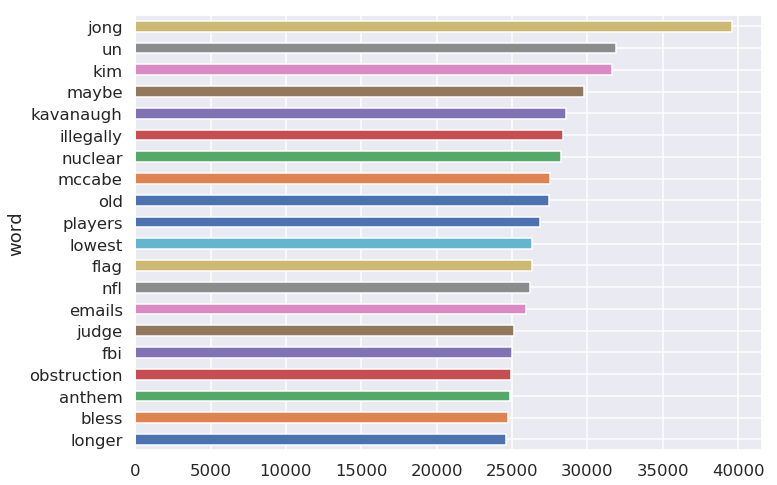

In [64]:
top_20['retweet_count'].sort_values().plot.barh(figsize=(10, 8));

## Question 7b

"kim", "jong" and "un" are apparently really popular in Trump's tweets! It seems like we can conclude that his tweets involving jong are more popular than his other tweets. Or can we?

Consider each of the statements about possible confounding factors below. State whether each statement is true or false and explain. If the statement is true, state whether the confounding factor could have made kim jong un related tweets higher in the list than they should be.

1. We didn't restrict our word list to nouns, so we have unhelpful words like "let" and "any" in our result.
1. We didn't remove hashtags in our text, so we have duplicate words (eg. #great and great).
1. We didn't account for the fact that Trump's follower count has increased over time.

1) False, unhelpful words would be confounding if we were looking at the sum of retweets instead of averages, as these words would be present in all of the tweets; however since we took the average of the tweets, the effect of unhelpful words is mitigated since you would expect unhelpful words to have no correlation to retweet popularity.

2) False, our functions were built to account for these kinds of duplicates

3) True, older tweets probably have less retweets since fewer people had been following trump and would have retweeted his messages. A larger current follower base means his current tweets are likely retweeted by more people than his older ones.

## Question 8

Using the `trump` tweets construct an interesting plot describing a property of the data and discuss what you found below.

**Ideas:**

1. How has the sentiment changed with length of the tweets?
1. Does sentiment affect retweet count?
1. Are retweets more negative than regular tweets?
1. Are there any spikes in the number of retweets and do the correspond to world events? 
1. *Bonus:* How many Russian twitter bots follow Trump? 
1. What terms have an especially positive or negative sentiment?

You can look at other data sources and even tweets.


### Plot:

In [65]:
#trump.head()

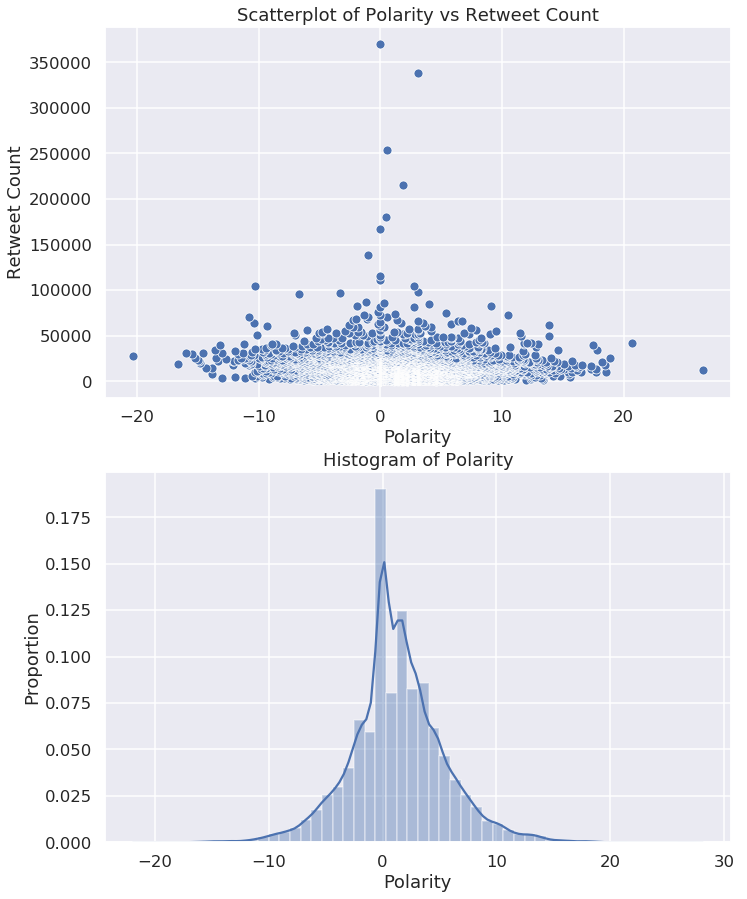

In [66]:
OrderedTweetCount = trump[['polarity','retweet_count']].sort_values(ascending = True, by = 'retweet_count')
plt.figure(figsize = (10, 15))
plt.subplot(2, 1, 1)
sns.scatterplot(OrderedTweetCount['polarity'], OrderedTweetCount['retweet_count'])
plt.ylabel('Retweet Count')
plt.xlabel('Polarity')
plt.title('Scatterplot of Polarity vs Retweet Count')
plt.subplot(2, 1, 2)
sns.distplot(OrderedTweetCount['polarity'])
plt.xlabel('Polarity')
plt.ylabel('Proportion')
plt.title('Histogram of Polarity')
plt.show()

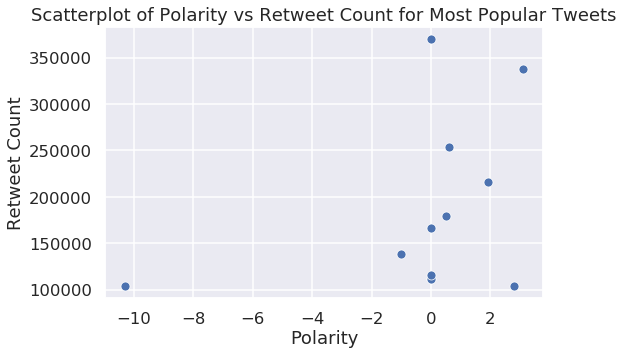

In [67]:
TopOrderedTweetCount = OrderedTweetCount[OrderedTweetCount['retweet_count'] > 100000]
plt.figure(figsize = (7, 5))
sns.scatterplot(TopOrderedTweetCount['polarity'], TopOrderedTweetCount['retweet_count'])
plt.ylabel('Retweet Count')
plt.xlabel('Polarity')
plt.title('Scatterplot of Polarity vs Retweet Count for Most Popular Tweets')
plt.show()

In [68]:
trump.sort_values(ascending = False, by = 'retweet_count')['text'].head(11)

ID
881503147168071680                                                                                                                                                                                                                                                  #fraudnewscnn #fnn https://t.co/wyunhjjujg
795954831718498305                                                                                                                                                                                                                                                          today we make america great again!
929511061954297857                                                                                                             why would kim jong-un insult me by calling me "old," when i would never call him "short and fat?" oh well, i try so hard to be his friend - and maybe someday that will happen!
796315640307060738                                                                      

### Discussion of Your Plot:

Initially I plotted the tweets all together in a scatterplot. I had a hypothesis that tweets with more negative polarity would have the most retweets out of 'outrage', with people seeking to share the sometimes wild things the president has said. If this correlation existed, I would've expected to see a negative linear correlation between the two variables. However, looking at the resulting scatterplot, as well as the histogram of polarity, there is large variation for tweets with under 50,000 retweets and what in the first graph looks like the top retweeted tweets center around 0. The scatterplot has a pyramid shape with farthest points at greater than 20 and less than -20, implying that there is much variation at the lower retweet counts but overall no significant correlations as you get to higher counts. The histogram is pretty symmetrical, although technically bimodal, with peak around 0 and smaller peak around 2.

I made the second plot to take a closer look at tweets with over 100,000 retweets, and even still the distribution of data points don't have an obvious pattern of relationship. I was however surprised that the highest retweeted tweets seemed to have more of a positve polarity than a negative one, with polarities from 0 - 3. This seemed odd to me so I decided to take a look at the actual content of the tweets themselves

The actual content of the tweets is as expected: mostly overall inflammatory or outrageous statements. This demonstrates that while the VADER lexicon can provide a good estimate about a statement's sentiment, it isn't always correct or great at picking up things like sarcasm. Moreover, the top tweet has a polarity of zero since none of the content of the tweet matches up to actual words in the VADER lexicon, which is another shortcoming. 

## Submission

Congrats, you just finished Project 1!

## Submission

You're done!

Before submitting this assignment, ensure to:

1. Restart the Kernel (in the menubar, select Kernel->Restart & Run All)
2. Validate the notebook by clicking the "Validate" button

Finally, make sure to **submit** the assignment via the Assignments tab in Datahub